# Phân tích thị trường tài chính bằng PCA từ dữ liệu cổ phiếu S&P 500

### 0. Cài đặt, nhập thư viện vào bài làm

In [47]:
# !pip install yfinance pandas

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [49]:
from datetime import datetime, timedelta

pd.options.display.float_format = '{:.2f}'.format

## 1. Thu thập và xử lý dữ liệu

### Tải danh sách cổ phiếu thuộc chỉ số S&P 500 (wikipedia)

In [50]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url, header=0)[0]
tickers = [ticker.replace('.', '-') for ticker in sp500['Symbol'].tolist()]

### Dùng thư viện yfinance để lấy dữ liệu giá đóng cửa (Close) của toàn bộ các cổ phiếu trong khoảng thời gian 1 năm gần đây

In [51]:
# # Thiết lập thời gian
# end_date = datetime.today().strftime('%Y-%m-%d')
# start_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')

# # Lấy dữ liệu giá đóng cửa của các cổ phiếu S&P 500
# data = yf.download(tickers, start=start_date, end=end_date)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


### Tải thêm dữ liệu chỉ số thị trường S&P 500 thực tế (mã: ^GSPC)

In [52]:
# # Lấy dữ liệu chỉ số S&P 500 (^GSPC)
# sp500_index = yf.download('^GSPC', start=start_date, end=end_date)['Close']

# # Lưu dữ liệu ra file (tuỳ chọn)
# # data.to_csv('sp500_stocks_close.csv')
# # sp500_index.to_csv('sp500_index_close.csv')

# print("\nDữ liệu đã tải xong.")

[*********************100%***********************]  1 of 1 completed


Dữ liệu đã tải xong.


### Tiền xử lý dữ liệu

In [53]:
print(data.info())
print(sp500_index.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-04-25 to 2025-04-24
Columns: 503 entries, A to ZTS
dtypes: float64(503)
memory usage: 984.4 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-04-25 to 2025-04-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None


In [54]:
data.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-25,135.36,169.09,161.43,163.01,104.76,88.48,303.60,473.44,194.71,58.77,...,253.88,30.64,95.51,53.10,117.37,129.16,138.84,118.70,292.53,151.66
2024-04-26,136.72,168.50,154.02,164.23,105.42,86.44,302.63,477.56,198.67,57.91,...,247.98,30.24,94.80,52.09,114.11,130.93,139.04,118.30,297.21,156.67
2024-04-29,138.56,172.68,155.86,162.25,105.16,86.77,297.86,473.07,200.57,58.48,...,249.45,30.36,95.89,52.59,115.73,131.12,140.43,120.64,300.01,157.93
2024-04-30,136.03,169.53,156.94,158.57,103.89,88.95,295.65,462.83,197.33,56.52,...,248.17,29.38,90.62,51.86,114.41,129.25,138.53,119.22,314.56,157.48
2024-05-01,137.67,168.50,156.05,156.16,104.20,91.10,293.44,469.39,190.72,56.24,...,251.69,29.41,91.69,51.91,112.24,129.51,132.73,118.51,309.05,156.75


#### Mô tả tập dữ liệu giá cổ phiếu S&P 500
Tập dữ liệu bao gồm 503 cột, 250 dòng 2024-04-25 đến 2025-04-24.

Loại dữ liệu: Giá đóng cửa hằng ngày (Close) của các cổ phiếu thuộc chỉ số S&P 500.

**Cấu trúc:** 

- Cột: Mỗi cột là một mã cổ phiếu (Ticker), ví dụ: A, AAPL, ABBV, ACN, XOM, ZTS...

- Chỉ số dòng (Index): Là ngày giao dịch, định dạng YY-MM-DD, ví dụ: 24-04-24, 24-04-25...

- Giá trị: Là giá đóng cửa thực tế của từng cổ phiếu vào cuối mỗi ngày giao dịch.

- Tần suất dữ liệu: Hằng ngày (daily).

**Mục đích sử dụng điển hình:**

- Tính tỉ suất sinh lợi hằng ngày (daily returns).

- Thực hiện phân tích PCA, tương quan, rủi ro danh mục.

- Xây dựng các chỉ số tổng hợp như PC1_index.

In [55]:
# Kiểm tra số NaN theo từng cổ phiếu (từng cột)
nan_per_stock = data.isna().sum().to_frame(name='n_nan')

# Lọc ra những mã có ít nhất 1 NaN
nan_stocks = nan_per_stock[nan_per_stock['n_nan'] > 0]

# In ra
print("Các mã cổ phiếu có dữ liệu bị thiếu (NaN):")
print(nan_stocks.sort_values(by='n_nan', ascending=False))

Các mã cổ phiếu có dữ liệu bị thiếu (NaN):
        n_nan
Ticker       
SW         49


In [73]:
# In kết quả
print("Tỉ lệ giữa NaN so với tổng số ngày giao dịch là: ")
print(nan_per_stock['n_nan'].sum() / data.shape[0])

Tỉ lệ giữa NaN so với tổng số ngày giao dịch là: 
0.196


Cổ phiếu SW (Smurfit WestRock) đã có nhiều ngày không được giao dịch do ảnh hưởng từ sự kiện sáp nhập giữa Smurfit Kappa và WestRock vào tháng 7/2024. Việc tạm dừng giao dịch có thể xuất phát từ thủ tục chuyển đổi mã cổ phiếu, tâm lý nhà đầu tư thận trọng, hoặc quy định tạm ngừng để hoàn tất hợp nhất. Đây là hiện tượng bình thường sau sáp nhập và cần được xử lý trong phân tích dữ liệu.

In [57]:
# xử lý Na
data.drop(columns=['SW'], inplace= True)

#### Tính tỉ suất sinh lợi hằng ngày (daily return) cho từng cổ phiếu

In [58]:
daily_return = data.pct_change().dropna()

## 2.	Tự xây dựng PCA từ đầu (from scratch)



### Chuẩn hóa dữ liệu return theo từng cổ phiếu để có trung bình bằng 0

In [59]:
# Bước 1: Chuẩn hóa dữ liệu return (mean = 0, std = 1)
returns_standardized = (daily_return - daily_return.mean()) / daily_return.std()

##### Kiểm tra dữ liệu

In [60]:
returns_standardized.mean()   # Kết quả nên gần 0 cho từng cổ phiếu

Ticker
A       0.00
AAPL    0.00
ABBV   -0.00
ABNB    0.00
ABT    -0.00
        ... 
XYL     0.00
YUM    -0.00
ZBH    -0.00
ZBRA   -0.00
ZTS     0.00
Length: 502, dtype: float64

In [61]:
print(returns_standardized.std())    # Kết quả nên gần 1 cho từng cổ phiếu

Ticker
A      1.00
AAPL   1.00
ABBV   1.00
ABNB   1.00
ABT    1.00
       ... 
XYL    1.00
YUM    1.00
ZBH    1.00
ZBRA   1.00
ZTS    1.00
Length: 502, dtype: float64


### Tính ma trận hiệp phương sai (covariance matrix) của các return (giữa các cổ phiếu)

In [62]:
# Bước 2: Tính ma trận hiệp phương sai
cov_matrix = np.cov(returns_standardized.T)

### Tính trị riêng (eigenvalues) và vector riêng (eigenvectors)

In [63]:
# Bước 3: Tính trị riêng (eigenvalues) và vector riêng (eigenvectors)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [64]:
print(np.max(np.abs(np.imag(eigenvalues))))  # nếu nhỏ hơn 1e-10 => ổn

1.9808298304844335e-15


In [65]:
# Loại bỏ phần ảo nếu có (chỉ lấy phần thực)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

### Sắp xếp các thành phần chính theo thứ tự giảm dần của trị riêng

In [66]:
# Bước 4: Sắp xếp theo thứ tự giảm dần của trị riêng
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

### Dựng thành phần chính đầu tiên (PC1) và biểu diễn PC1 theo thời gian

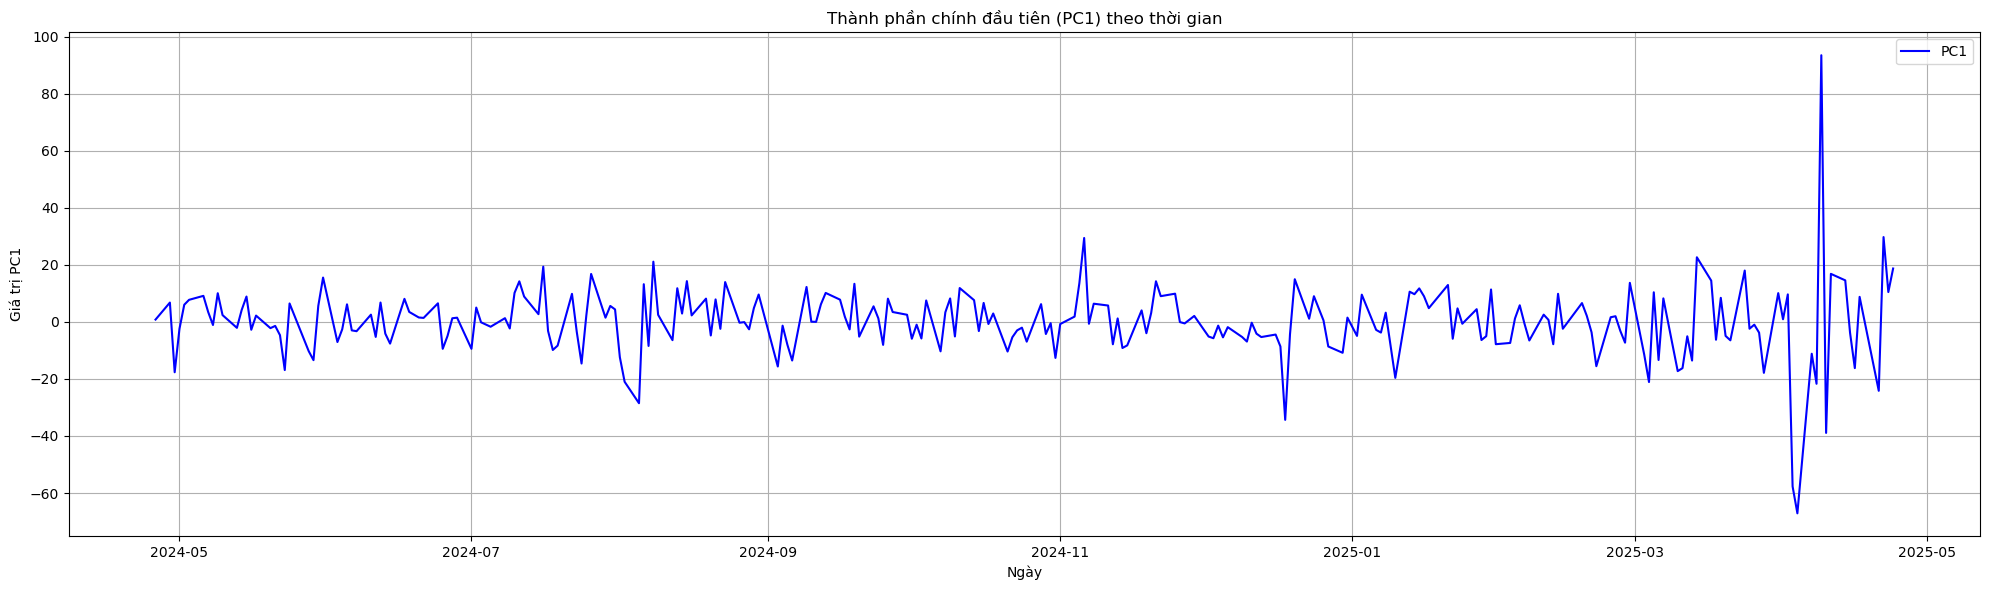

In [67]:
# Bước 5: Tính thành phần chính đầu tiên (PC1)
PC1 = returns_standardized @ eigenvectors[:, 0]

# Bước 6: Biểu diễn PC1 theo thời gian
plt.figure(figsize=(20, 6))
plt.plot(returns_standardized.index, PC1, label='PC1', color='blue')
plt.title("Thành phần chính đầu tiên (PC1) theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Giá trị PC1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

#### **Nhận xét**

Thành phần chính đầu tiên (PC1), được trích xuất thông qua phân tích PCA trên tập dữ liệu gồm 500 cổ phiếu thuộc S&P 500, đại diện cho **xu hướng biến động chung nhất** trong toàn bộ thị trường chứng khoán Mỹ.  

Về bản chất, PC1 đóng vai trò như một **chỉ báo định lượng của “động lực thị trường tổng quát”**, tức là phản ánh **mức độ đồng pha** giữa các cổ phiếu. Khi giá trị PC1 tăng mạnh hoặc giảm mạnh, điều đó cho thấy đa số cổ phiếu trong danh mục đang cùng biến động theo một chiều—dù là tích cực hay tiêu cực.  

Qua biểu đồ PC1 theo thời gian, có thể thấy phần lớn giai đoạn từ giữa 2024 đến đầu 2025, PC1 dao động quanh mức 0 với biên độ vừa phải, cho thấy thị trường không có sự đồng thuận rõ rệt. Tuy nhiên, giai đoạn tháng 3–4/2025 xuất hiện các đột biến cực lớn về giá trị PC1—cho thấy **một cú sốc hệ thống ảnh hưởng đồng thời đến toàn bộ thị trường**. Điều này phù hợp với các sự kiện thực tế, khi thị trường Mỹ chịu tác động từ chính sách thuế quan diện rộng của chính quyền Tổng thống Trump, dẫn đến làn sóng bán tháo quy mô lớn và biến động cực đoan trên diện rộng.

Mức độ biến động của PC1 trong thời gian đó cho thấy đây là **yếu tố phản ánh hiệu quả những cú sốc vĩ mô và rủi ro hệ thống**. Đồng thời, việc PC1 không có mối tương quan cao với chỉ số S&P 500 trong toàn bộ giai đoạn cũng cho thấy rằng **trục biến động này không hoàn toàn trùng khớp với cách tính vốn hóa trọng số của chỉ số thị trường**, mà mang tính trung bình thống kê trên toàn bộ danh mục.

#### **Sự kiện chính gây biến động thị trường:**

- **Ngày 2 tháng 4, 2025 ("Liberation Day")**: Tổng thống Trump công bố áp dụng mức thuế 10% lên hầu hết hàng nhập khẩu, cùng với các mức thuế cao hơn đối với nhiều quốc gia, bao gồm Trung Quốc
- **Ngày 3–4 tháng 4, 2025**: Thị trường phản ứng tiêu cực, với S&P 500 giảm tổng cộng 10.5% trong hai ngày—mức giảm hai ngày lớn nhất kể từ năm 2020

- **Ngày 9 tháng 4, 2025**: Chính quyền thông báo tạm dừng áp dụng một số mức thuế trong 90 ngày, dẫn đến sự phục hồi mạnh mẽ của thị trường

- **Ngày 10 tháng 4, 2025**: Tuy nhiên, thị trường lại giảm mạnh do lo ngại về sự không chắc chắn trong chính sách thuế quan



## 3 Phân tích và trực quan hoá PC1

### Tạo biến mới (PC1_index) bằng cách nhân giá với trọng số từ PC1, vẽ đồ thị PC1_index theo thời gian

In [68]:
# Sử dụng giá (hoặc return gốc cũng được) nhân với trọng số PC1
PC1_index = data @ eigenvectors[:, 0]

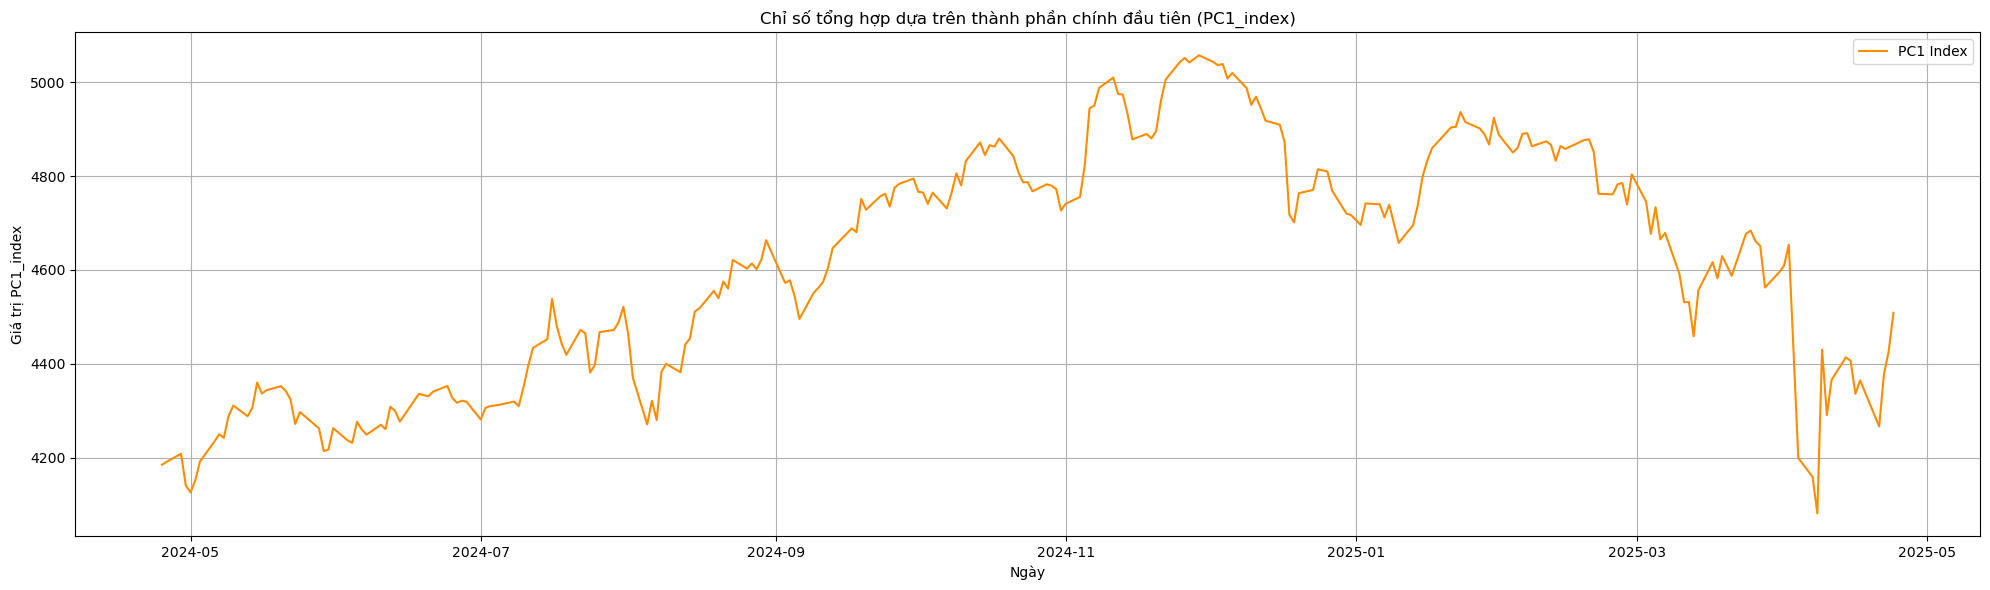

In [69]:
plt.figure(figsize=(20, 6))
plt.plot(data.index, PC1_index, label='PC1 Index', color='darkorange')
plt.title("Chỉ số tổng hợp dựa trên thành phần chính đầu tiên (PC1_index)")
plt.xlabel("Ngày")
plt.ylabel("Giá trị PC1_index")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Vẽ thêm đường biểu diễn chỉ số S&P 500 thực tế trong cùng khung thời gian để so sánh

In [70]:
# Bước 1: Đặt tên cho Series PC1_index
PC1_index.name = 'PC1_index'
# Bước 2: Gộp hai chỉ số lại (sẽ tự động khớp theo ngày)
df_compare = pd.concat([PC1_index, sp500_index], axis=1).dropna()
# Bước 3: Chuẩn hóa cả hai về mốc đầu = 100
df_compare_norm = df_compare / df_compare.iloc[0] * 100

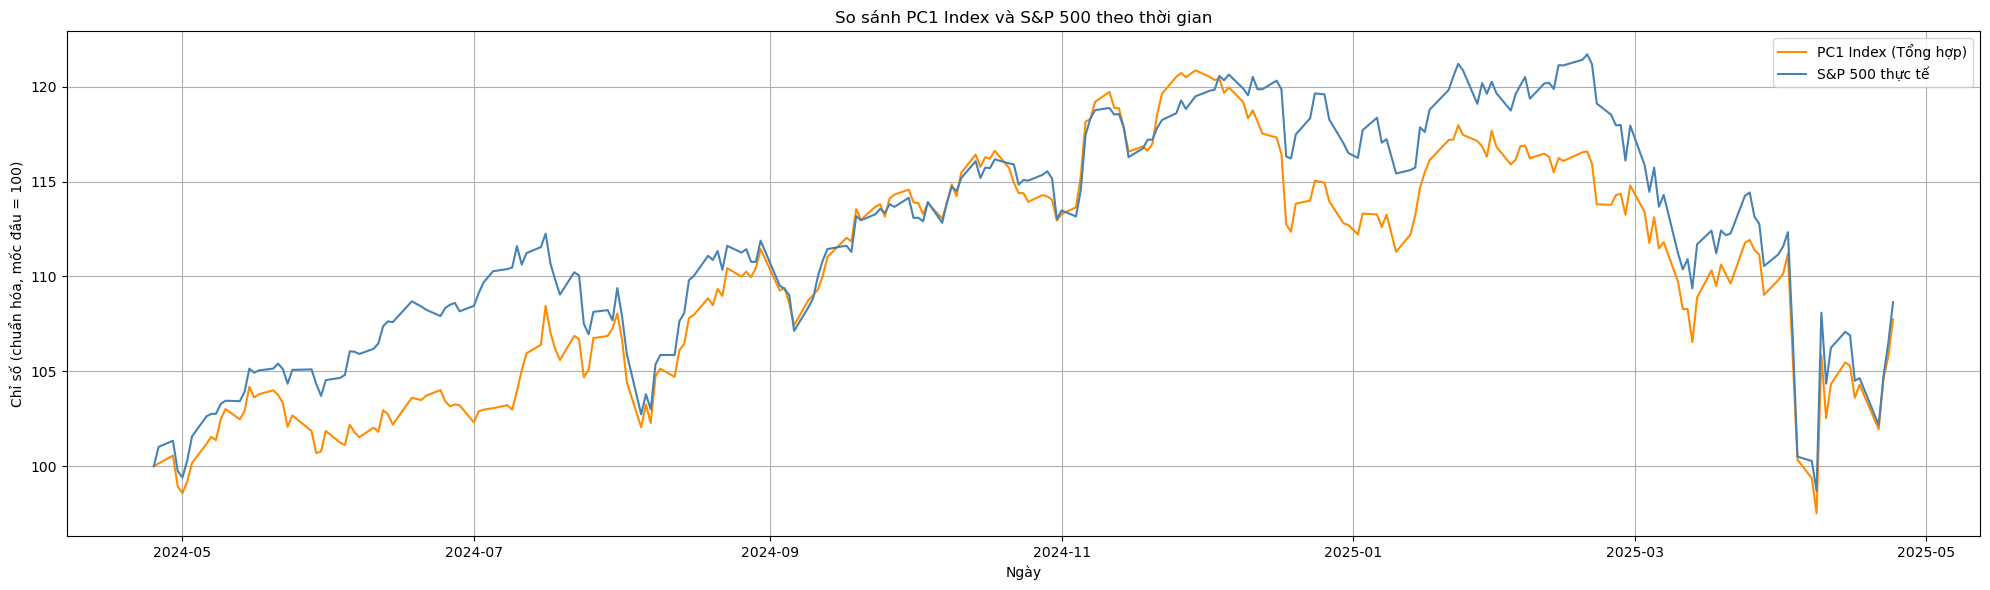

In [71]:
# Bước 4: Vẽ biểu đồ
plt.figure(figsize=(20, 6))
plt.plot(df_compare_norm.index, df_compare_norm['PC1_index'], label='PC1 Index (Tổng hợp)', color='darkorange')
plt.plot(df_compare_norm.index, df_compare_norm['^GSPC'], label='S&P 500 thực tế', color='steelblue')
plt.title('So sánh PC1 Index và S&P 500 theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Chỉ số (chuẩn hóa, mốc đầu = 100)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Tính hệ số tương quan giữa PC1_index và S&P 500 để đánh giá định lượng mối liên hệ giữa chúng

In [72]:
correlation = df_compare['PC1_index'].corr(df_compare['^GSPC'])

print(f"Hệ số tương quan giữa PC1_index và S&P 500: {correlation:.4f}")

Hệ số tương quan giữa PC1_index và S&P 500: 0.9443


### Giải thích kết quả

**Nhận xét biểu đồ so sánh PC1_index và S&P 500 (2024–2025)**

Biểu đồ thể hiện sự so sánh giữa **PC1_index** (chỉ số tổng hợp xây dựng từ thành phần chính đầu tiên của PCA) và **chỉ số thị trường S&P 500 thực tế**, trong khoảng thời gian từ tháng 5/2024 đến tháng 4/2025, sau khi được chuẩn hóa về cùng mốc xuất phát (100).

#### 1. **Mức độ tương quan rất cao: r = 0.9443**

Với hệ số tương quan đạt **0.9443**, có thể khẳng định rằng **PC1_index tái hiện rất sát biến động thực tế của thị trường S&P 500**. Điều này cho thấy:
- **Thành phần chính đầu tiên (PC1)** chiếm phần lớn phương sai của toàn bộ danh mục cổ phiếu S&P 500.
- **PC1_index** có thể được xem như một **chỉ báo tổng hợp thay thế hiệu quả** cho chỉ số S&P 500, đặc biệt trong các mô hình định lượng.

#### 2. **Xu hướng và cấu trúc biến động đồng pha**

- Từ **05/2024 đến đầu 2025**, cả hai chỉ số đều có **đà tăng ổn định**, với các pha điều chỉnh ngắn hạn tương tự nhau.
- Trong giai đoạn **khủng hoảng tháng 3–4/2025** (gắn với chính sách thuế quan mới từ chính quyền Tổng thống Trump), **cả hai chỉ số đều giảm mạnh**, với **PC1_index phản ứng hơi sớm và biên độ mạnh hơn** — phản ánh khả năng nhạy bén của PC1 đối với biến động đồng loạt trong thị trường.

#### 3. **Ý nghĩa tài chính của PC1_index**

- PC1_index đại diện cho **xu hướng biến động chung mạnh nhất của toàn bộ thị trường**, không bị chi phối bởi vài mã có vốn hóa cực lớn như trong S&P 500.
- Do đó, PC1_index có thể xem là **chỉ báo nội tại** của thị trường, phù hợp dùng trong:
  - Mô hình rủi ro hệ thống
  - Mô hình định giá tài sản có yếu tố ẩn
  - Xây dựng chỉ số tổng hợp không phụ thuộc vốn hóa

